In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))
from beer_knowledge import number_of_beer_per_style, add_global_knowledge, add_local_knowledge, add_experts, get_expert_per_day, get_global_expert_per_day

sns.set_theme()

In [84]:
df_ba_beers     = pd.read_csv('../data/beer_advocate/beers.csv')
df_ba_breweries = pd.read_csv('../data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('../data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('../data/beer_advocate/ratings.csv')

In [85]:
df_rb_beers     = pd.read_csv('../data/rate_beer/beers.csv')
df_rb_breweries = pd.read_csv('../data/rate_beer/breweries.csv')
df_rb_users     = pd.read_csv('../data/rate_beer/users.csv')
df_rb_ratings   = pd.read_csv('../data/rate_beer/ratings.csv')

In [86]:
df_ba_ratings['day']     = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('D')
df_ba_ratings['week']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_ba_ratings['month']   = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_ba_ratings['quarter'] = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Q')
df_ba_ratings['year']    = pd.to_datetime(df_ba_ratings['date'], unit='s').dt.to_period('Y')

df_rb_ratings['day']     = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('D')
df_rb_ratings['week']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_rb_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Q')
df_rb_ratings['year']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Y')

# Pre-processing 

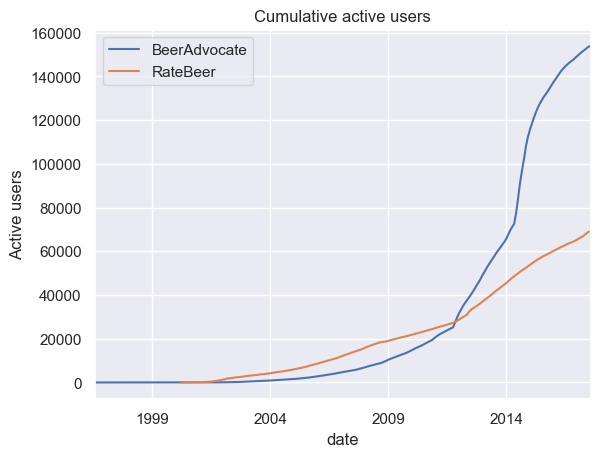

In [87]:
plt.title('Cumulative active users')
plt.xlabel('Month')
plt.ylabel('Active users')
pd.to_datetime(df_ba_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='BeerAdvocate')
pd.to_datetime(df_rb_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='RateBeer')
plt.legend()

In [88]:
def compute_cumulative_ratings_count(dataframe: pd.DataFrame):
    dataframe = dataframe.sort_values(['date'])
    dataframe['_count'] = 1
    dataframe['cumulative_ratings_count'] = dataframe['_count'].cumsum()
    dataframe = dataframe.drop(columns=['_count'])
    return dataframe

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

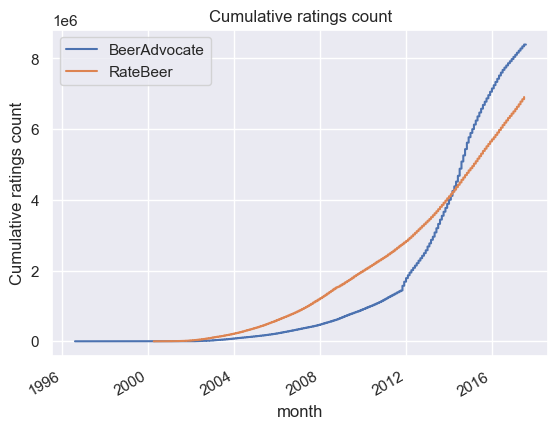

In [89]:
fig, ax = plt.subplots()
plt.title('Cumulative ratings count')
plt.xlabel('Month')
plt.ylabel('Cumulative ratings count')
compute_cumulative_ratings_count(df_ba_ratings).plot(x='month', y='cumulative_ratings_count', label='BeerAdvocate', ax=ax)
compute_cumulative_ratings_count(df_rb_ratings).plot(x='month', y='cumulative_ratings_count', label='RateBeer', ax=ax)

**Internet majority adoption is around 2004 (50% of population using it regularly) + lot of noise before 2004 so the analysis will focus on the time period after January 2004**

In [90]:
def remove_before_month(dataframe: pd.DataFrame, month: str = '2004-01') -> pd.DataFrame:
    dataframe = dataframe.sort_values(['user_id', 'date'])
    dataframe = dataframe.merge(
        (dataframe.groupby('user_id')['month'].first() >= month).reset_index().rename(columns={'month': 'is_first_rating_after_month'}),
        on='user_id'
    )
    dataframe = dataframe[dataframe['is_first_rating_after_month']]
    dataframe = dataframe.drop(columns=['is_first_rating_after_month'])
    return dataframe

In [91]:
df_ba_ratings = remove_before_month(df_ba_ratings, '2004-01')
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

# 1. Inflations

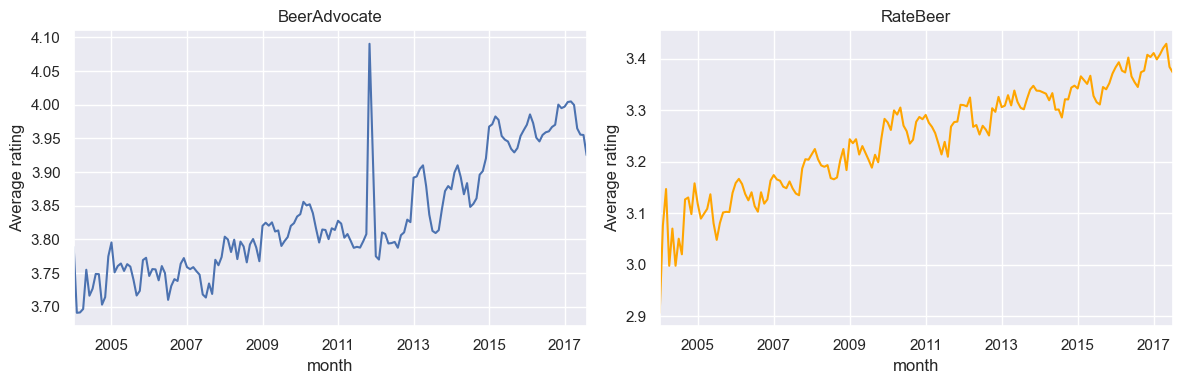

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

In [93]:
def create_time_serie(dataframe: pd.DataFrame, time_column: str, value_column: str, frequency: str = 'W') -> pd.DataFrame:
    full_range = pd.DataFrame(index=pd.date_range(start=dataframe[time_column].min(), end=dataframe[time_column].max(), freq=frequency).to_period('W').start_time)
    partial_time_serie = dataframe.groupby(time_column)[value_column].mean()
    time_serie = pd.merge(full_range, partial_time_serie, left_index=True, right_index=True, how='left').fillna(0)
    return time_serie

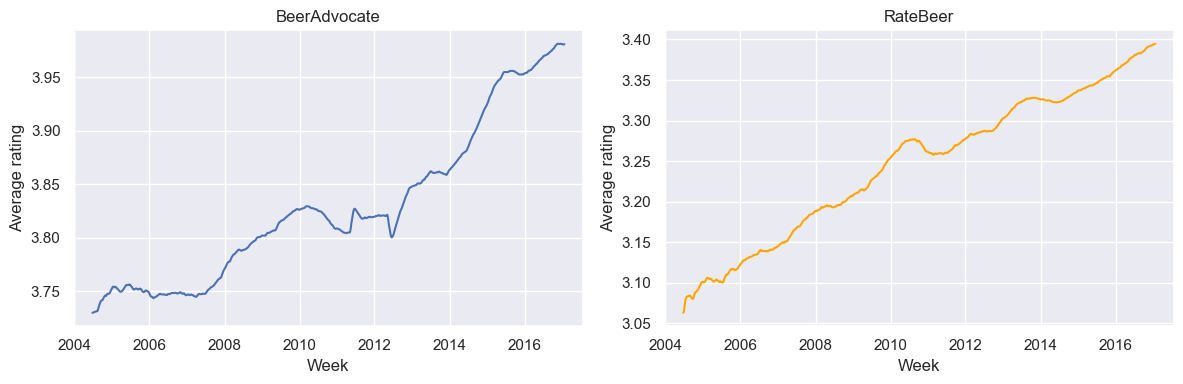

In [94]:
df_ba_decomposition = seasonal_decompose(create_time_serie(df_ba_ratings, 'week', 'rating'), model='additive', period=52)
df_rb_decomposition = seasonal_decompose(create_time_serie(df_rb_ratings, 'week', 'rating'), model='additive', period=52)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating general trend')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_decomposition.trend.plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_decomposition.trend.plot(ax=axs[1], color='orange')

plt.tight_layout()

In [95]:
def correct_inflation(dataframe: pd.DataFrame, trend: pd.Series) -> pd.DataFrame:
    trend = trend.dropna()
    reference_mean = trend.iloc[0]
    IPC = trend / reference_mean
    
    dataframe = dataframe.loc[dataframe['week'] >= trend.index[0]]

    beta_0 = IPC.iloc[0]
    beta_1 = (IPC.iloc[-1] - IPC.iloc[0]) / len(IPC)

    for week in pd.date_range(start=IPC.index.max(), end=dataframe['week'].max(), freq='W').to_period('W').start_time:
        diff = (week + pd.Timedelta(weeks=1) - IPC.index.min()) / pd.Timedelta(weeks=1)
        IPC.loc[week + pd.Timedelta(weeks=1)] = beta_0 + beta_1 * diff
    
    dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
    return dataframe

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_49205/3935964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_49205/3935964417.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values


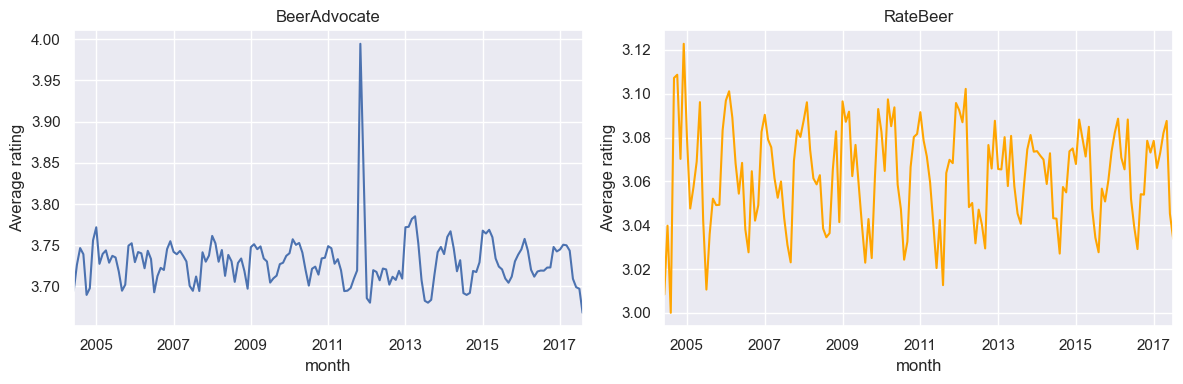

In [96]:
df_ba_ratings = correct_inflation(df_ba_ratings, df_ba_decomposition.trend)
df_rb_ratings = correct_inflation(df_rb_ratings, df_rb_decomposition.trend)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating average over time corrected for inflation')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average rating')
df_ba_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

# 2. Rating scales

In [97]:
def compute_scale_distribution(dataframe: pd.DataFrame) -> pd.DataFrame:
    new_dataframe = dataframe.groupby('user_id')['rating_corrected'].quantile([0.01, 0.025, 0.05, 0.1, 0.9, 0.95, 0.975, 0.99]).unstack()
    new_dataframe = new_dataframe.merge(dataframe.groupby('user_id')['rating_corrected'].count(), left_index=True, right_index=True)
    new_dataframe = new_dataframe.rename(columns={'rating_corrected': 'count'}).dropna()
    new_dataframe['difference'] = new_dataframe[0.975] - new_dataframe[0.025]
    new_dataframe.columns = [str(c) for c in new_dataframe.columns]
    return new_dataframe

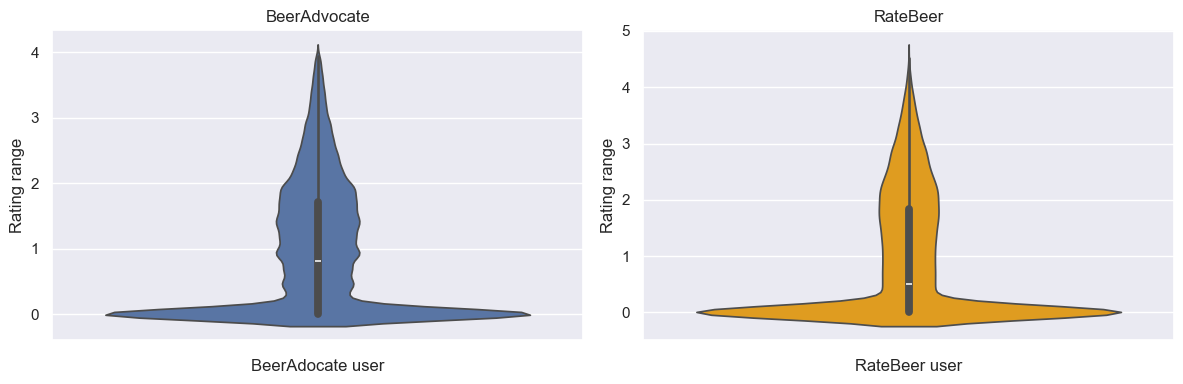

In [98]:
df_ba_scales = compute_scale_distribution(df_ba_ratings)
df_rb_scales = compute_scale_distribution(df_rb_ratings)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Distribution of rating range')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(df_ba_scales['difference'], ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales['difference'], ax=axs[1], color='orange')

plt.tight_layout()

In [99]:
for threshold in [10, 50, 100, 500, 1000]:
    df_ba_scales[f'at_least_{threshold}'] = (df_ba_scales['count'] > threshold).astype(int) * threshold
    df_rb_scales[f'at_least_{threshold}'] = (df_rb_scales['count'] > threshold).astype(int) * threshold

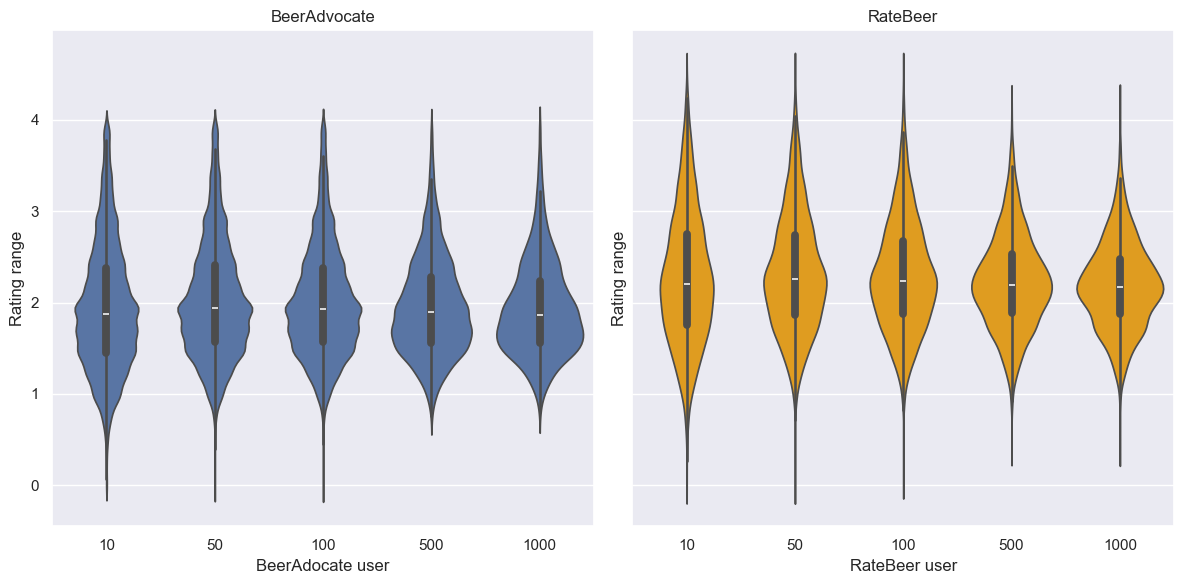

In [100]:
df_ba_scales = pd.wide_to_long(df_ba_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])
df_rb_scales = pd.wide_to_long(df_rb_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.title('Distribution of rating ranges')

axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('BeerAdocate user')
axs[0].set_ylabel('Rating range')
sns.violinplot(data=df_ba_scales[df_ba_scales['count'] > df_ba_scales['threshold']], x='threshold', y='difference', ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales[df_rb_scales['count'] > df_rb_scales['threshold']], x='threshold', y='difference', ax=axs[1], color='orange')

plt.tight_layout()

# Past ratings and count

In [101]:
def get_past_ratings_count_and_average(
    df_ratings: pd.DataFrame,
    sorting_columns: list[str],
    grouping_columns: list[str],
    name: str,
    shift: bool,
) -> pd.DataFrame:
    df_ratings = df_ratings.sort_values(sorting_columns, kind="stable")

    if shift:
        df_ratings[f"{name}_past_ratings_count"] = df_ratings.groupby(
            grouping_columns
        ).cumcount()
        df_ratings[f"{name}_past_ratings_average"] = (
            df_ratings.groupby(grouping_columns)["rating_corrected"]
            .expanding()
            .mean()
            .shift()
            .reset_index(level=[i for i in range(len(grouping_columns))], drop=True)
        )
    else:
        df_ratings[f"{name}_past_ratings_count"] = (
            df_ratings.groupby(grouping_columns).cumcount() + 1
        )
        df_ratings[f"{name}_past_ratings_average"] = (
            df_ratings.groupby(grouping_columns)["rating_corrected"]
            .expanding()
            .mean()
            .reset_index(level=[i for i in range(len(grouping_columns))], drop=True)
        )

    df_ratings.loc[
        df_ratings[f"{name}_past_ratings_count"] == 0, f"{name}_past_ratings_average"
    ] = pd.NA

    df_ratings = df_ratings.sort_index()
    return df_ratings

def get_past_ratings_counts_all_style(
    df_ratings: pd.DataFrame, dummy_column: str, multiplying_columns_prefix: str
) -> pd.DataFrame:
    # Create one-hot encoded binary matrix for the beer styles
    beer_styles_one_hot_encoding = pd.get_dummies(
        df_ratings[dummy_column], dtype=int, prefix="user_past_ratings"
    ).replace(0, pd.NA)

    # Multiply the binary matrix with the past ratings count and average corresponding to the current rating style
    df_user_beer_style_past_ratings = pd.merge(
        beer_styles_one_hot_encoding.mul(
            df_ratings[f"{multiplying_columns_prefix}_past_ratings_count"], axis=0
        ),
        beer_styles_one_hot_encoding.mul(
            df_ratings[f"{multiplying_columns_prefix}_past_ratings_average"], axis=0
        ),
        left_index=True,
        right_index=True,
        suffixes=("_count", "_average"),
    )

    modified_columns = [
        column
        for column in df_user_beer_style_past_ratings.columns
        if ("_count" in column or "_average" in column)
    ]

    # Merge to get the user id and date in order to forward fill the values within groups of user_id
    df_user_beer_style_past_ratings = df_user_beer_style_past_ratings.merge(
        df_ratings[["user_id", "date", "beer_id"]],
        left_index=True,
        right_index=True,
        how="left",
    )

    # Ensure duplicate are well sorted by the next sorting
    df_user_beer_style_past_ratings.sort_index(inplace=True)

    # Fill forward the values within groups of user_id
    df_user_beer_style_past_ratings[modified_columns] = (
        df_user_beer_style_past_ratings.sort_values(["user_id", "date"], kind="stable")
        .groupby("user_id")
        .ffill()[modified_columns]
    )

    # Shift the value forward to have the counts and average without taking into
    # account the current rating (since counts and average are computed taking
    # into account current rating)
    df_user_beer_style_past_ratings[modified_columns] = (
        df_user_beer_style_past_ratings.sort_values(["user_id", "date"], kind="stable")
        .groupby("user_id")
        .shift(1)[modified_columns]
    )

    # Fill remaining cells with 0 as they are cells of ratings occuring before
    # the first rating in a given beer style
    df_user_beer_style_past_ratings[modified_columns] = df_user_beer_style_past_ratings[
        modified_columns
    ].fillna(0.0)

    return df_user_beer_style_past_ratings



In [102]:
df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings, ["user_id", "date"], ["user_id"], "user", shift=True
)

df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings, ["beer_id", "date"], ["beer_id"], "beer", shift=True
)

df_ba_ratings = get_past_ratings_count_and_average(
    df_ba_ratings,
    ["user_id", "beer_global_style", "date"],
    ["user_id", "beer_global_style"],
    "user_beer_style",
    shift=False,
)

df_ba_user_beer_style_past_ratings = get_past_ratings_counts_all_style(
    df_ba_ratings, "beer_global_style", "user_beer_style"
)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_49205/1277939718.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0.0)


In [103]:
df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings, ["user_id", "date"], ["user_id"], "user", shift=True
)

df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings, ["beer_id", "date"], ["beer_id"], "beer", shift=True
)

df_rb_ratings = get_past_ratings_count_and_average(
    df_rb_ratings,
    ["user_id", "beer_global_style", "date"],
    ["user_id", "beer_global_style"],
    "user_beer_style",
    shift=False,
)

df_rb_user_beer_style_past_ratings = get_past_ratings_counts_all_style(
    df_rb_ratings, "beer_global_style", "user_beer_style"
)

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_49205/1277939718.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0.0)


In [104]:
df_ba_user_beer_style_past_ratings.to_csv("../data/beer_advocate/user_beer_style_past_ratings_inflation.csv",index=False)
df_rb_user_beer_style_past_ratings.to_csv("../data/rate_beer/user_beer_style_past_ratings_inflation.csv",index=False)

In [105]:
df_rb_ratings.to_csv("../data/rate_beer/ratings_inflation.csv",index=False)
df_ba_ratings.to_csv("../data/beer_advocate/ratings_inflation.csv",index=False)

# Knowledge

In [3]:
#df_rb_full_ratings = pd.read_csv("../data/rate_beer/ratings.csv")
df_ba_full_ratings = pd.read_csv("../data/beer_advocate/ratings.csv")

In [4]:
df_ba_full_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_ba_full_ratings["user_beer_style_past_ratings_count"] - 1
df_ba_full_ratings.loc[df_ba_full_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan
df_ba_full_ratings['date_day']      = pd.to_datetime(df_ba_full_ratings['date'], unit="s").dt.round('D')
df_ba_full_ratings.drop(df_ba_full_ratings[df_ba_full_ratings["beer_global_style"] == "Low Alcohol Beer"].index, axis=0, inplace=True)

In [5]:
df_current_beer_per_style = number_of_beer_per_style(df_ba_full_ratings)

In [56]:
df_ba_user_beer_style_past_ratings = pd.read_csv("../data/beer_advocate/user_beer_style_past_ratings_inflation.csv")
#df_rb_user_beer_style_past_ratings = pd.read_csv("../data/rate_beer/user_beer_style_past_ratings_inflation.csv")
#df_rb_ratings = pd.read_csv("../data/rate_beer/ratings_inflation.csv")
df_ba_ratings = pd.read_csv("../data/beer_advocate/ratings_inflation.csv")

In [57]:
df_ba_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_ba_ratings["user_beer_style_past_ratings_count"] - 1
df_ba_ratings.loc[df_ba_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan
df_ba_ratings['date_day'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.round('D')
df_ba_ratings.drop(df_ba_ratings[df_ba_ratings["beer_global_style"] == "Low Alcohol Beer"].index, axis=0, inplace=True)

#To preprocess once and for all
df_ba_user_beer_style_past_ratings['date_day'] = pd.to_datetime(df_ba_user_beer_style_past_ratings['date'], unit="s").dt.round('D')
df_ba_user_beer_style_past_ratings.drop(["user_past_ratings_Low Alcohol Beer_count","user_past_ratings_Low Alcohol Beer_average"],axis=1,inplace=True)

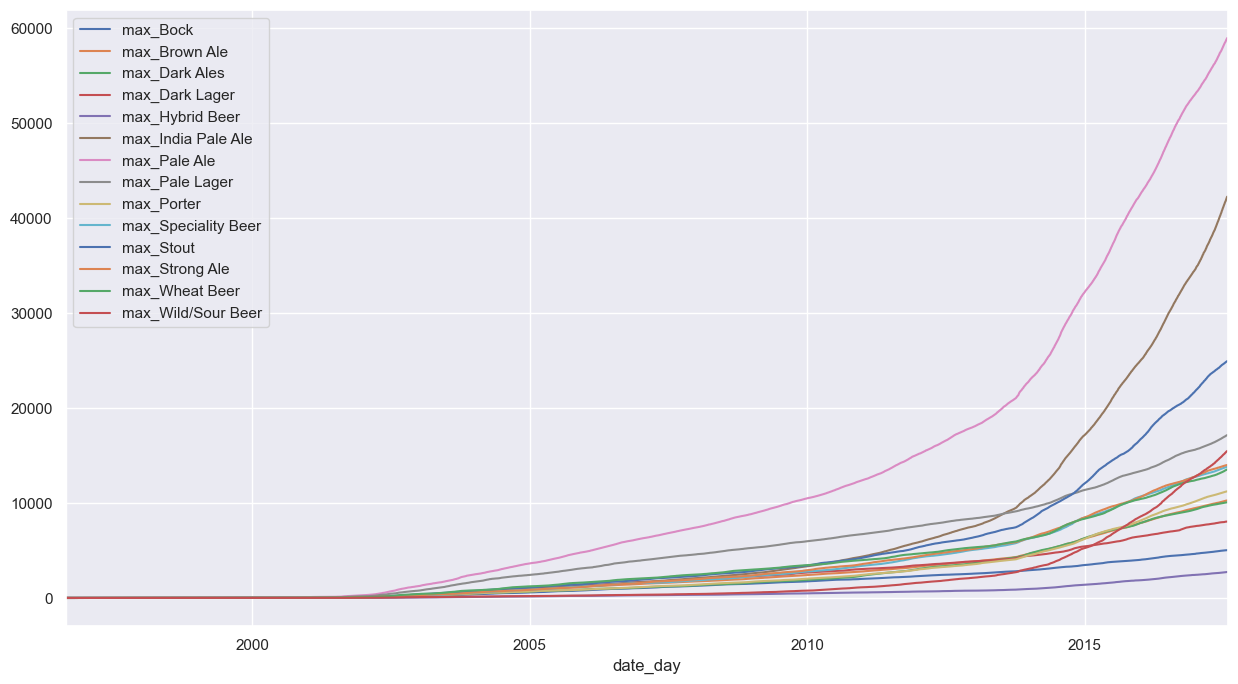

In [8]:
df_current_beer_per_style.plot(x="date_day",grid=True,figsize=(15,8))
plt.show()

In [9]:
average_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "average" in col]
count_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "count" in col]
max_columns = [col for col in df_current_beer_per_style.columns if "max" in col]

In [10]:
df_ba_user_beer_style_past_ratings = add_global_knowledge(df_current_beer_per_style, df_ba_user_beer_style_past_ratings, count_columns)
df_ba_user_beer_style_past_ratings, df_local_knowledge = add_local_knowledge(df_current_beer_per_style, df_ba_user_beer_style_past_ratings, max_columns, count_columns)

df_knowledge = df_ba_user_beer_style_past_ratings[["user_id","date_day","beer_id","global_knowledge","local_knowledge","style_tried"]]
df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"]+df_knowledge["local_knowledge"])/2

df_knowledge = df_knowledge.drop(df_knowledge[df_knowledge["local_knowledge"] == 0].index, axis=0)

df_prime_knowledge = df_knowledge[["user_id","global_knowledge","local_knowledge","knowledge"]].groupby("user_id").max().reset_index()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_56045/1020940568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knowledge.loc[:,"knowledge"] = (df_knowledge["global_knowledge"]+df_knowledge["local_knowledge"])/2


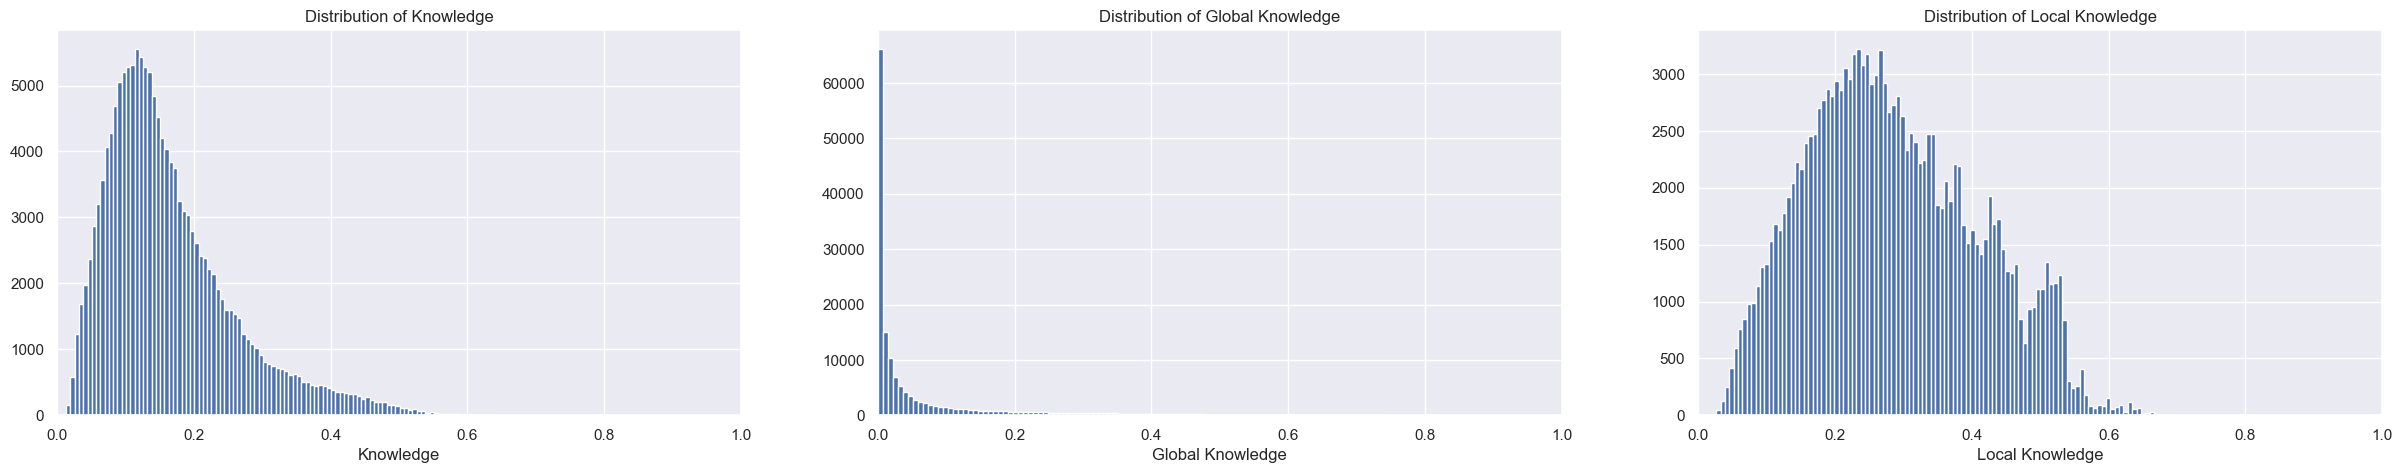

In [11]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
df_prime_knowledge["knowledge"].hist(bins=100)
plt.title("Distribution of Knowledge")
plt.xlabel("Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,2)
df_prime_knowledge["global_knowledge"].hist(bins=100)
plt.title("Distribution of Global Knowledge")
plt.xlabel("Global Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,3)
df_prime_knowledge["local_knowledge"].hist(bins=100)
plt.title("Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.xlim([0,1])

plt.show()

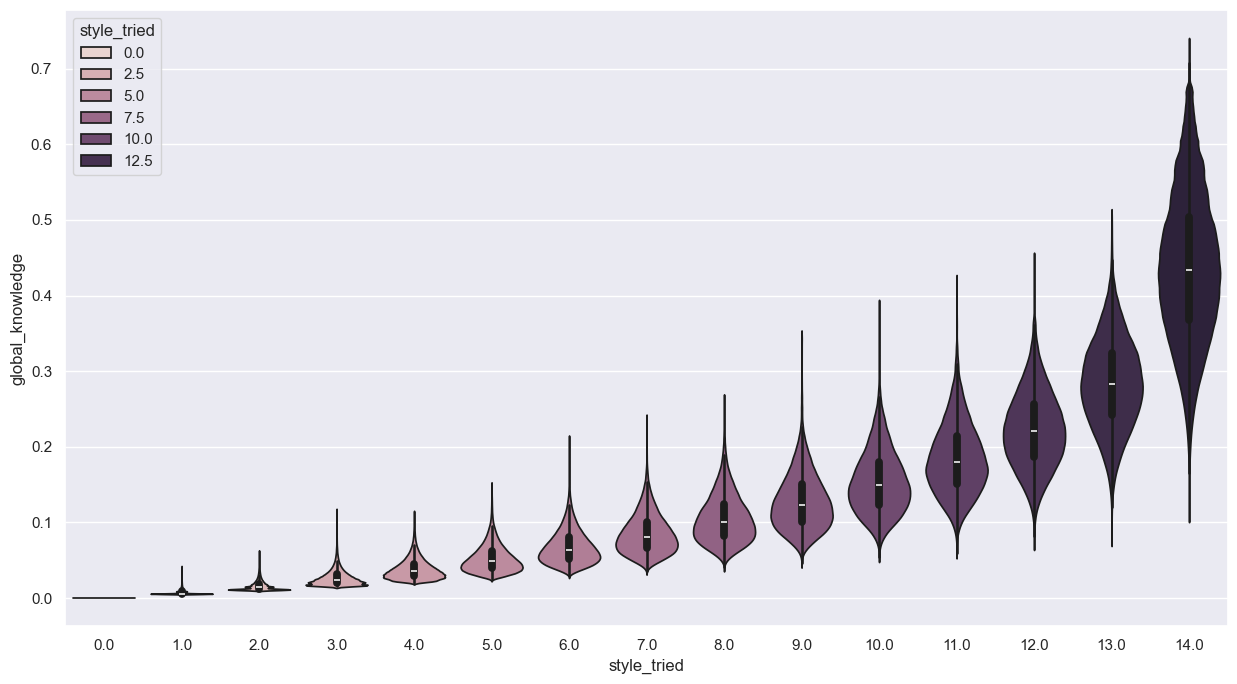

In [12]:
plt.figure(figsize=(15,8))
sns.violinplot(x=df_knowledge["style_tried"],y=df_knowledge["global_knowledge"],hue=df_knowledge["style_tried"])
plt.show()

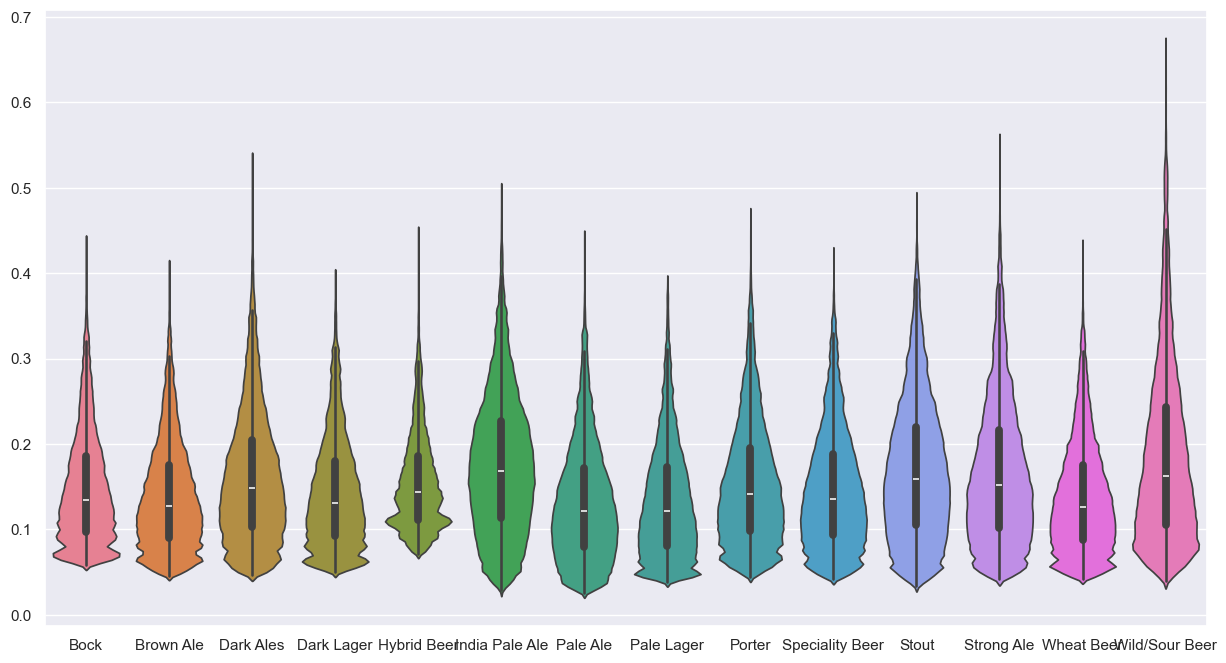

In [13]:
plt.figure(figsize=(15,8))
sns.violinplot(df_local_knowledge.iloc[:,:-1].replace(0,np.nan))
plt.show()

# Experts

In [14]:
df_users_past_beer_style, df_local_knowledge_quantile_expert = add_experts(df_local_knowledge, df_ba_user_beer_style_past_ratings)

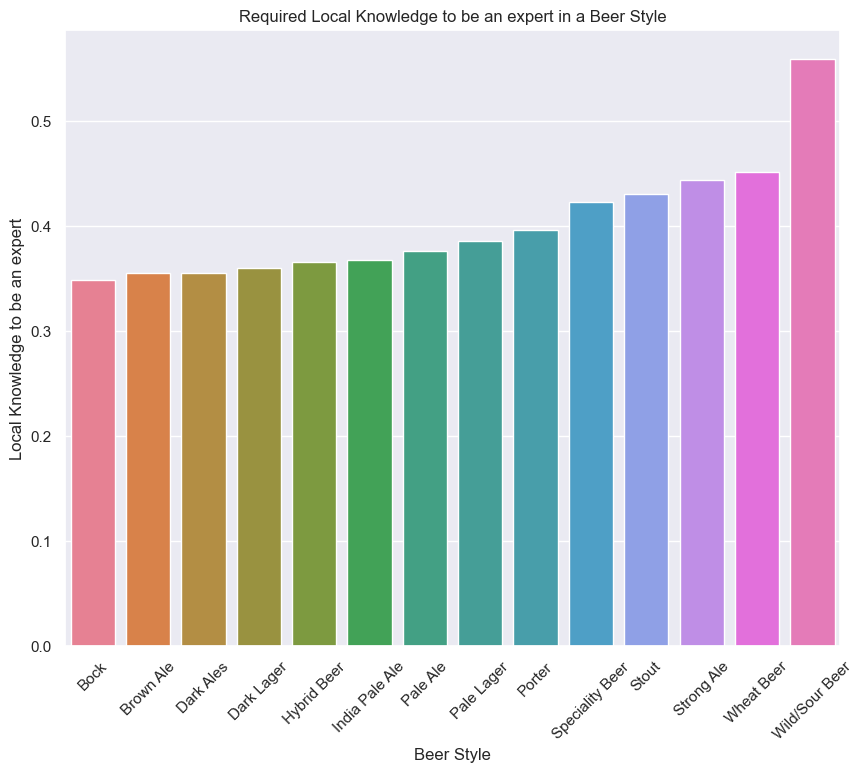

In [15]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_local_knowledge_quantile_expert.index, y=df_local_knowledge_quantile_expert.sort_values(), hue=df_local_knowledge_quantile_expert.index)
plt.xticks(rotation=45)
plt.ylabel("Local Knowledge to be an expert")
plt.xlabel("Beer Style")
plt.title("Required Local Knowledge to be an expert in a Beer Style")
plt.show()

In [16]:
max_available_beer_per_day = df_users_past_beer_style[max_columns+["date_day"]].groupby("date_day").max().reset_index()
max_available_beer_per_day.columns = ["date_day"] + df_local_knowledge_quantile_expert.index.to_list()
max_available_beer_per_day.iloc[:,1:] = max_available_beer_per_day.iloc[:,1:] * np.pow(df_local_knowledge_quantile_expert,3)
df_beer_required_to_be_expert_long = max_available_beer_per_day.melt(id_vars='date_day', var_name='Beer Style', value_name='Beers to be expert')

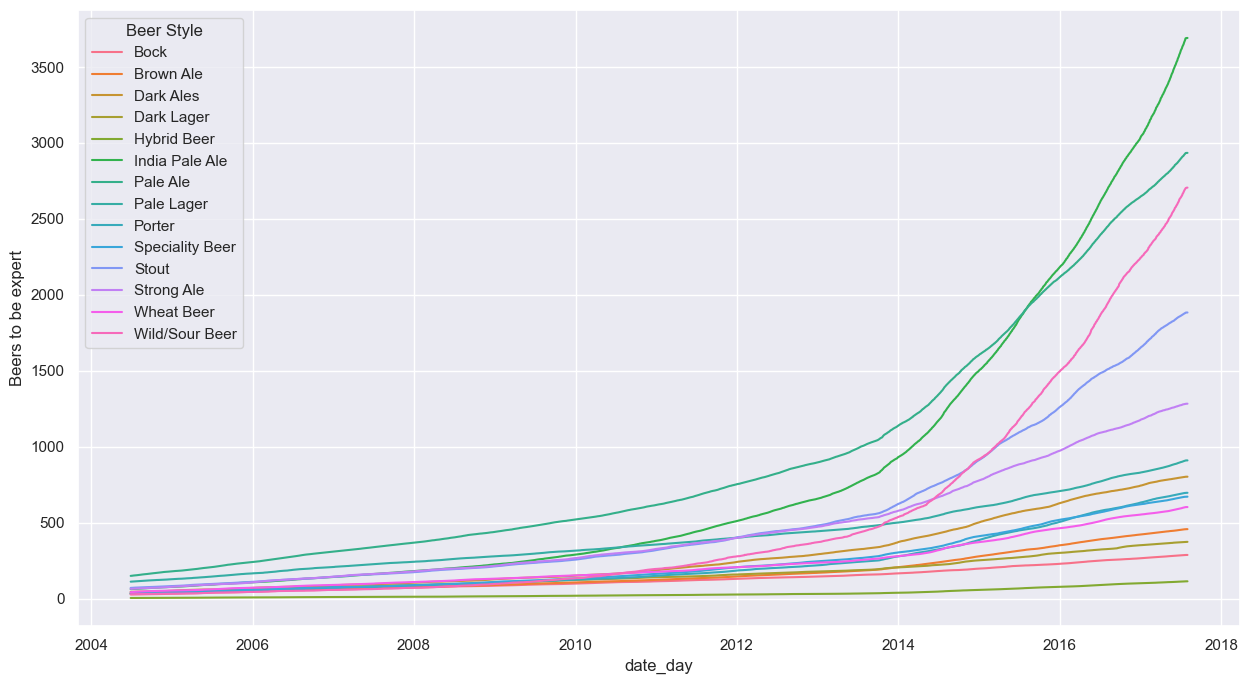

In [17]:
plt.figure(figsize=(15,8))
sns.lineplot(x=df_beer_required_to_be_expert_long["date_day"],y=df_beer_required_to_be_expert_long["Beers to be expert"], hue=df_beer_required_to_be_expert_long["Beer Style"])
plt.show()

In [20]:
expert_columns = [col for col in df_users_past_beer_style.columns if "expert" in col]
n_unique_experts_per_style = df_users_past_beer_style[expert_columns+["user_id"]].groupby("user_id").max().reset_index().iloc[:,1:].sum()

df_users_past_beer_style.loc[:,"isExpert"] = df_users_past_beer_style[expert_columns].sum(axis=1)
df_expert_users = df_users_past_beer_style.loc[df_users_past_beer_style["isExpert"] >= 1,["user_id"]+expert_columns].groupby("user_id").max().reset_index().merge(df_ba_users[["user_id","user_country"]], how="left", on="user_id")

In [21]:
df_expert_users = df_expert_users.merge(df_ba_users[["user_id","user_country_code"]], how="left", on="user_id")

In [37]:
df_count_exp = df_expert_users["user_country_code"].value_counts().reset_index()
df_count_exp["log_count"] = np.log(df_count_exp["count"])

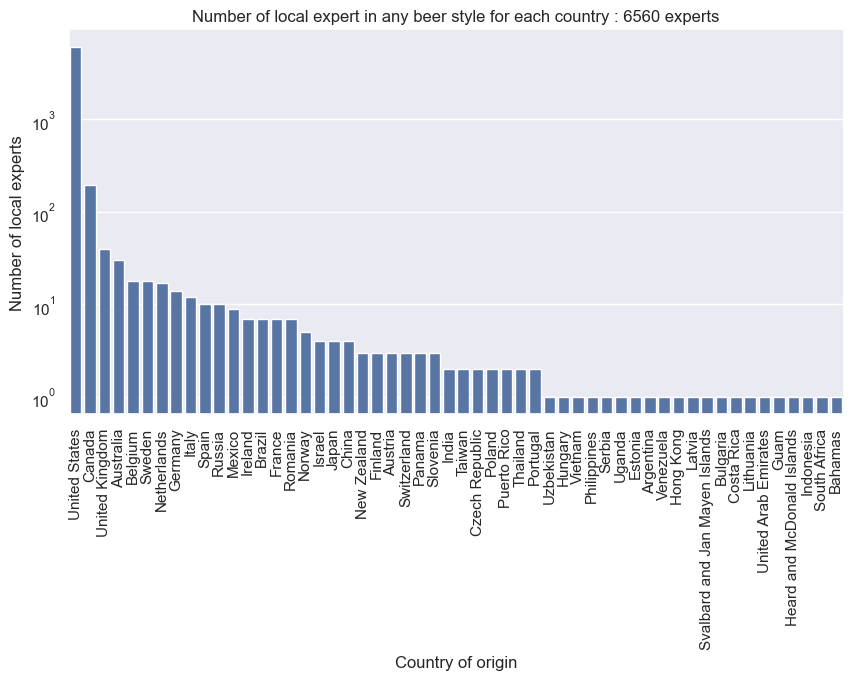

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(df_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.title(f"Number of local expert in any beer style for each country : {df_expert_users["user_country"].value_counts().sum().item()} experts")
plt.yscale("log")
plt.show()

In [32]:
import plotly.io as pio
pio.renderers.default = 'browser'  # Use browser for rendering

In [40]:
fig = px.choropleth(
    df_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis
)


# Update layout for better visualization
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type='mercator')
)

# Display the map
fig.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52782/2009303820.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52782/2009303820.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_52782/2009303820.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel

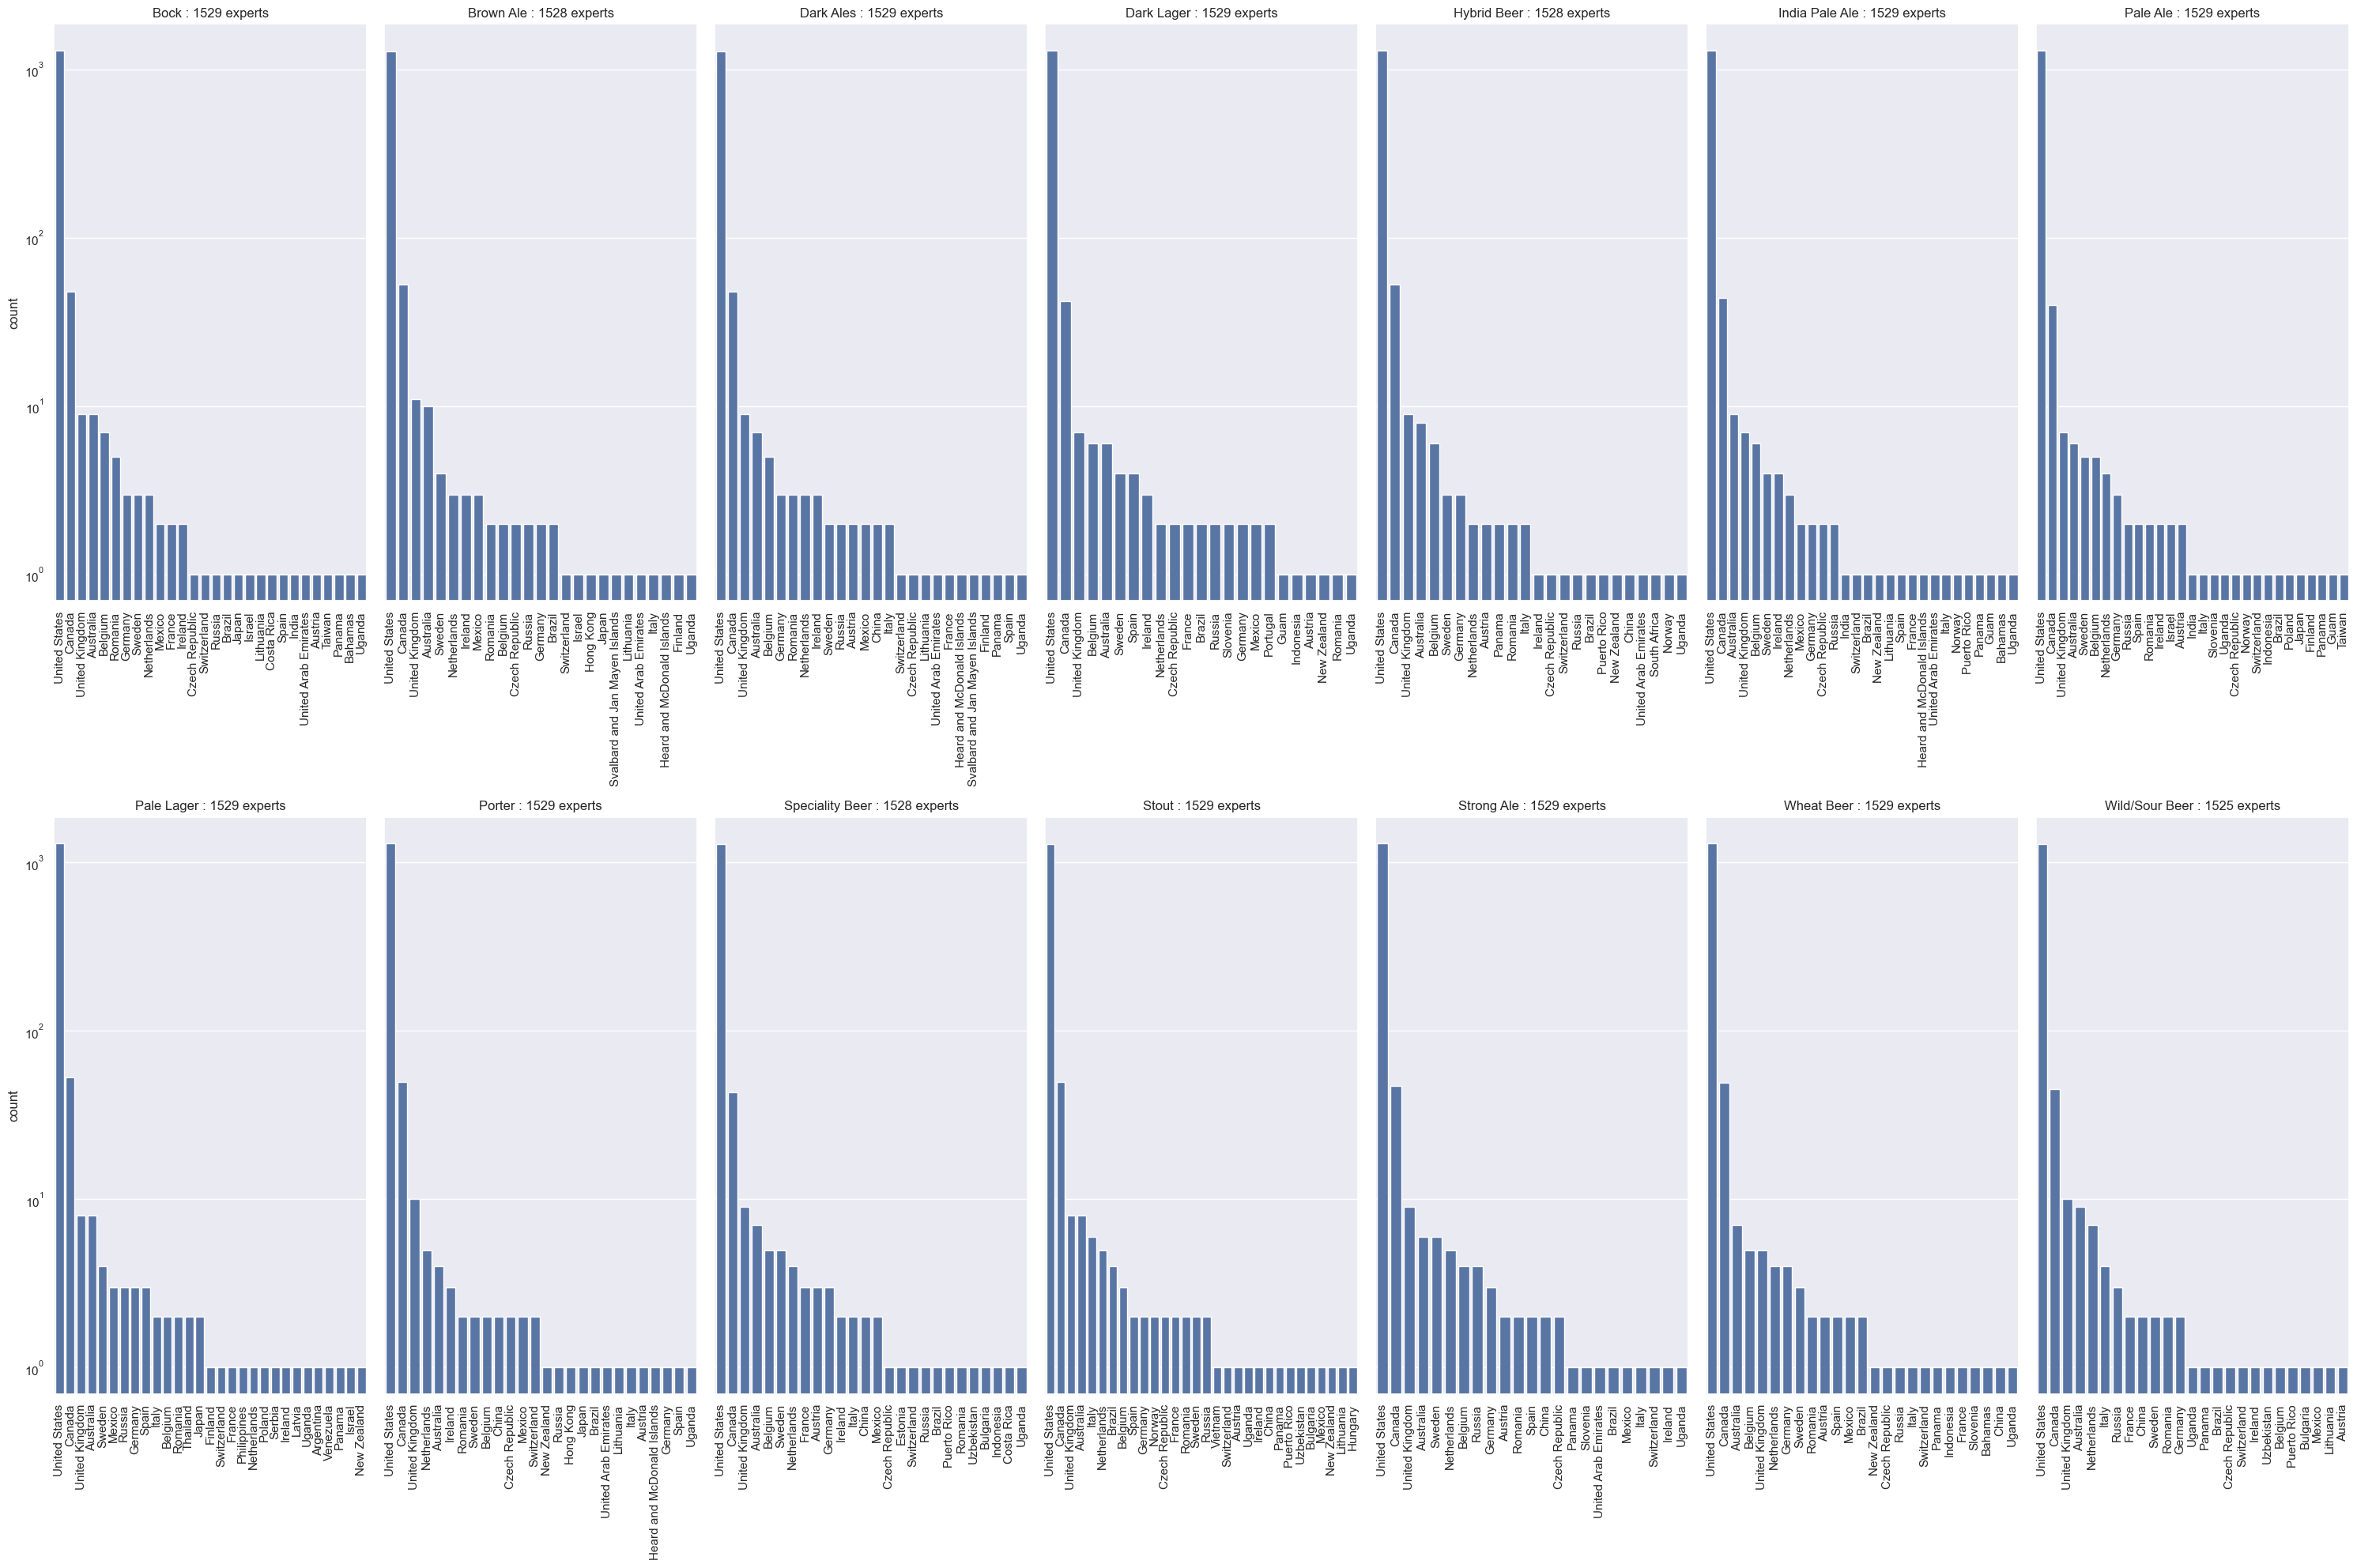

In [ ]:
fig, axes = plt.subplots(2,7,figsize=(30,20),sharey=True)
for col_idx, col in enumerate(expert_columns):
    sns.barplot(df_expert_users[df_expert_users[col] == 1]["user_country"].value_counts(), ax=axes[col_idx//7,col_idx%7])
    #axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
    axes[col_idx//7,col_idx%7].set_xlabel("")
    #plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx//7,col_idx%7].set_title(f"{col.split("_")[0]} : {df_expert_users[col].sum()} experts")
    axes[col_idx//7,col_idx%7].set_yscale("log")

plt.tight_layout()
plt.show()

In [44]:
n_unique_experts_per_style.sort_values()

Wild/Sour Beer_expert     1525
Brown Ale_expert          1528
Hybrid Beer_expert        1528
Speciality Beer_expert    1528
Bock_expert               1529
Dark Ales_expert          1529
Dark Lager_expert         1529
India Pale Ale_expert     1529
Pale Ale_expert           1529
Pale Lager_expert         1529
Porter_expert             1529
Stout_expert              1529
Strong Ale_expert         1529
Wheat Beer_expert         1529
dtype: int64

In [ ]:
df_users_past_beer_style['date_month'] = pd.to_datetime(df_ba_full_ratings['date'], unit="s").dt.to_period("M").dt.start_time

In [ ]:
df_expert_per_day = df_users_past_beer_style[expert_columns+["date_month","user_id"]].groupby(["user_id","date_month"]).max().reset_index().iloc[:,1:].groupby("date_month").sum().reset_index()
df_expert_per_day_long = df_expert_per_day.melt(id_vars='date_month', var_name='Beer Style', value_name='Number of expert ratings')

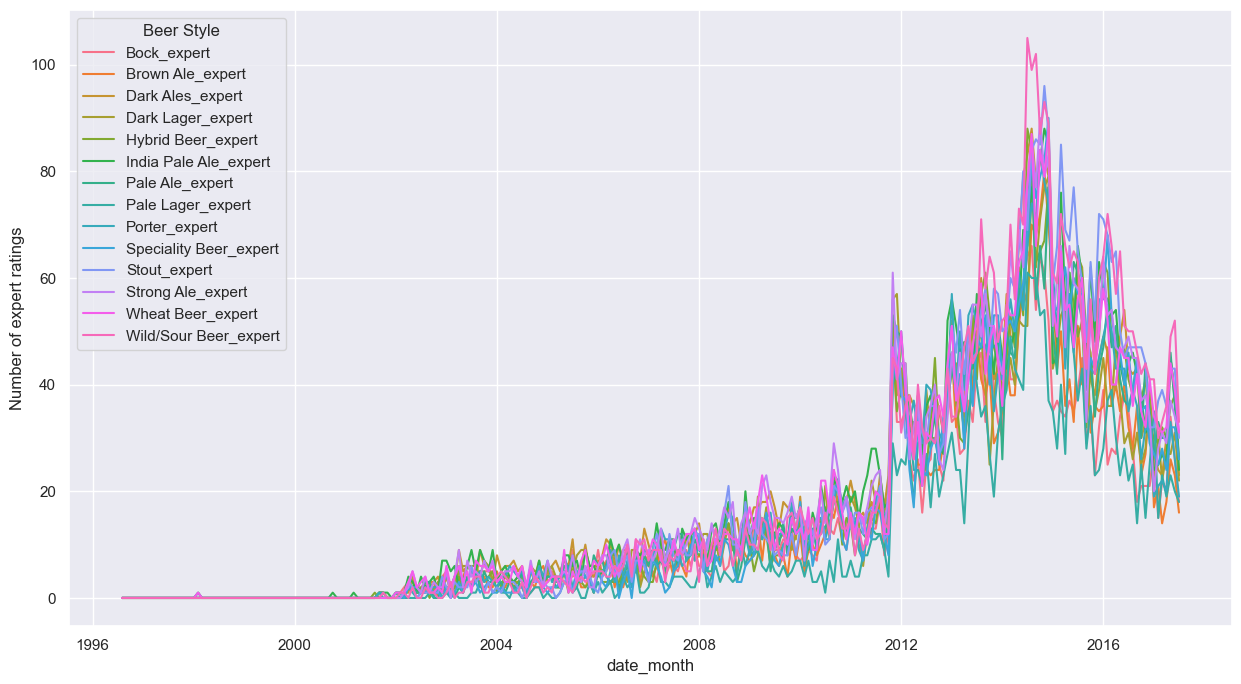

In [66]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_expert_per_day_long,x="date_month",y='Number of expert ratings', hue="Beer Style")
plt.show()

In [53]:
expert_per_day = get_expert_per_day(df_ba_ratings, df_users_past_beer_style, max_available_beer_per_day, expert_columns, count_columns)
df_expert_per_day_long = expert_per_day.melt(id_vars='date_day', var_name='Beer Style', value_name='Number of active expert')

In [57]:
df_expert_per_day_long

,date_day,Beer Style,Number of active expert
0,2004-06-28,expert_Bock,0
1,2004-06-29,expert_Bock,0
2,2004-06-30,expert_Bock,0
3,2004-07-01,expert_Bock,0
4,2004-07-02,expert_Bock,0
...,...,...,...
66957,2017-07-28,expert_Wild/Sour Beer,0
66958,2017-07-29,expert_Wild/Sour Beer,0
66959,2017-07-30,expert_Wild/Sour Beer,0
66960,2017-07-31,expert_Wild/Sour Beer,0


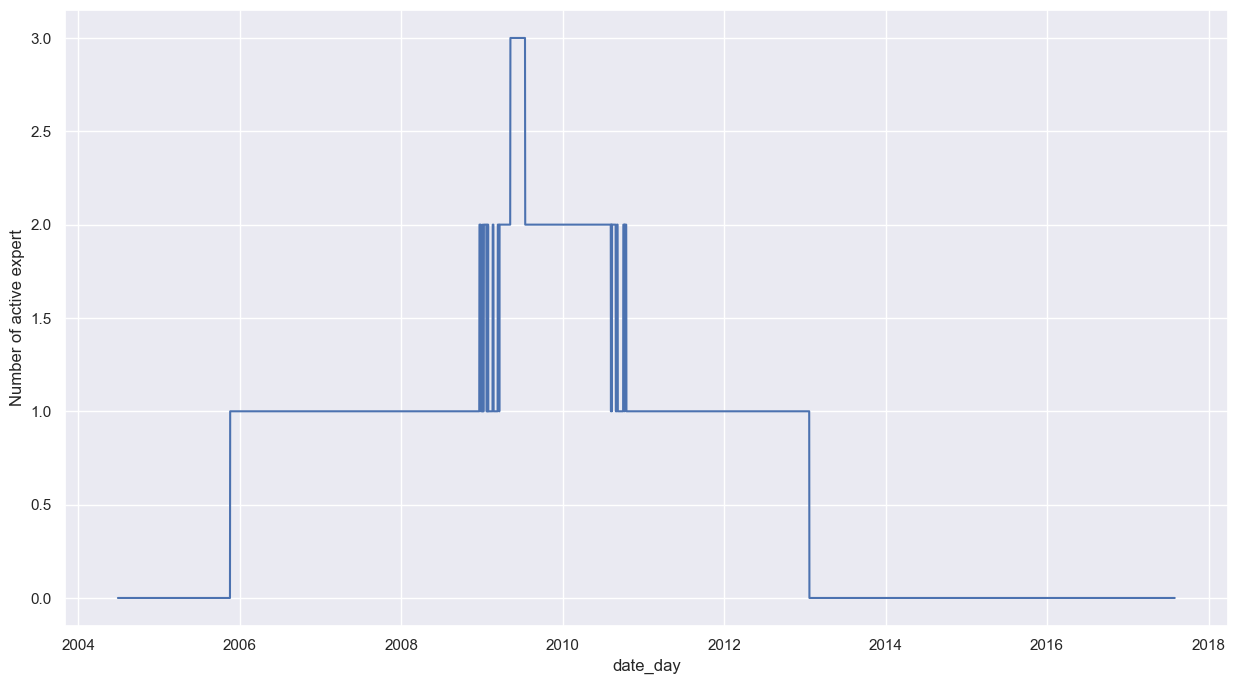

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_expert_per_day_long[df_expert_per_day_long["Beer Style"] == "expert_India Pale Ale"],x="date_day",y='Number of active expert')
plt.show()

In [58]:
df_expert_ratings = df_users_past_beer_style[expert_columns+["date_day","user_id","beer_id"]].groupby(["user_id","date_day"]).max().reset_index().merge(df_ba_ratings[["user_id","date_day","beer_global_style","rating"]], how="inner", on=["user_id","date_day"])
expert_means = []
k = 100
for style in expert_columns:
    beer_rated_by_experts = df_expert_ratings[(df_expert_ratings[style] == 1)]["beer_id"].unique()
    top_k_beers = df_ba_ratings[(df_ba_ratings["beer_global_style"] == style.split("_")[0]) & (df_ba_ratings["beer_id"].isin(beer_rated_by_experts))][["rating","beer_id"]].groupby("beer_id").count().reset_index().sort_values(by="rating",ascending=False).head(k)["beer_id"].to_numpy()
    df_same_beers = df_expert_ratings[(df_expert_ratings["beer_global_style"] == style.split("_")[0]) & (df_expert_ratings["beer_id"].isin(top_k_beers))]
    expert_means.append(df_same_beers[[style,"rating","beer_global_style"]].groupby([style,"beer_global_style"]).agg(["mean","sem"]).reset_index().rename(columns={style:"expert"}))
df_to_show = pd.concat(expert_means,axis=0)

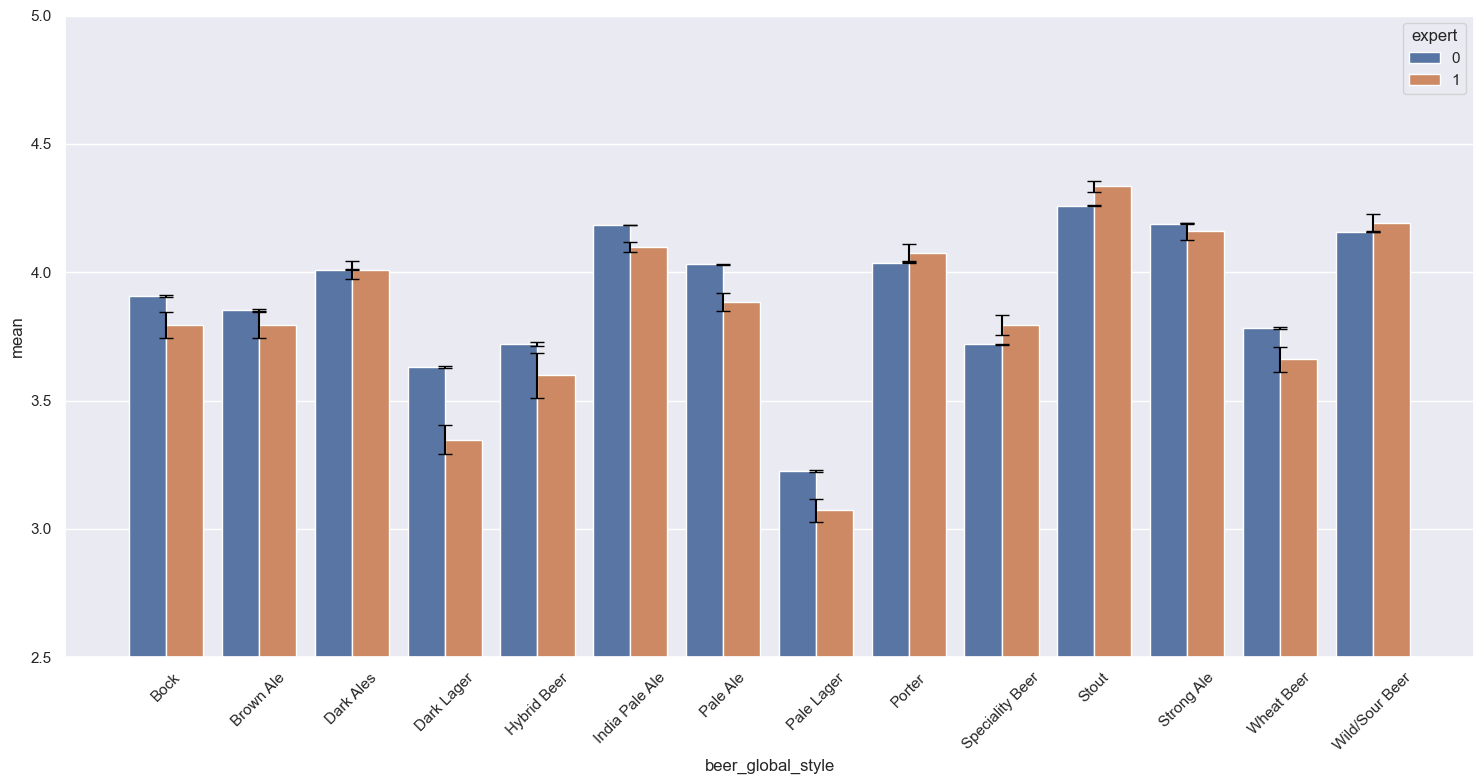

In [62]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_to_show["beer_global_style"], y=df_to_show["rating"]["mean"], hue=df_to_show["expert"])
plt.errorbar(x=df_to_show["beer_global_style"], y=df_to_show["rating"]["mean"], yerr=df_to_show["rating"]["sem"], fmt="none", c="black", capsize=5)
plt.xticks(rotation=45)
plt.ylim([2.5,5.0])
plt.tight_layout()
plt.show()

In [50]:
df_experts = df_users_past_beer_style[expert_columns+["user_id","date_day"]]
df_ba_ratings = df_ba_ratings.dropna()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_56045/1418684443.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_56045/1418684443.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_56045/1418684443.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

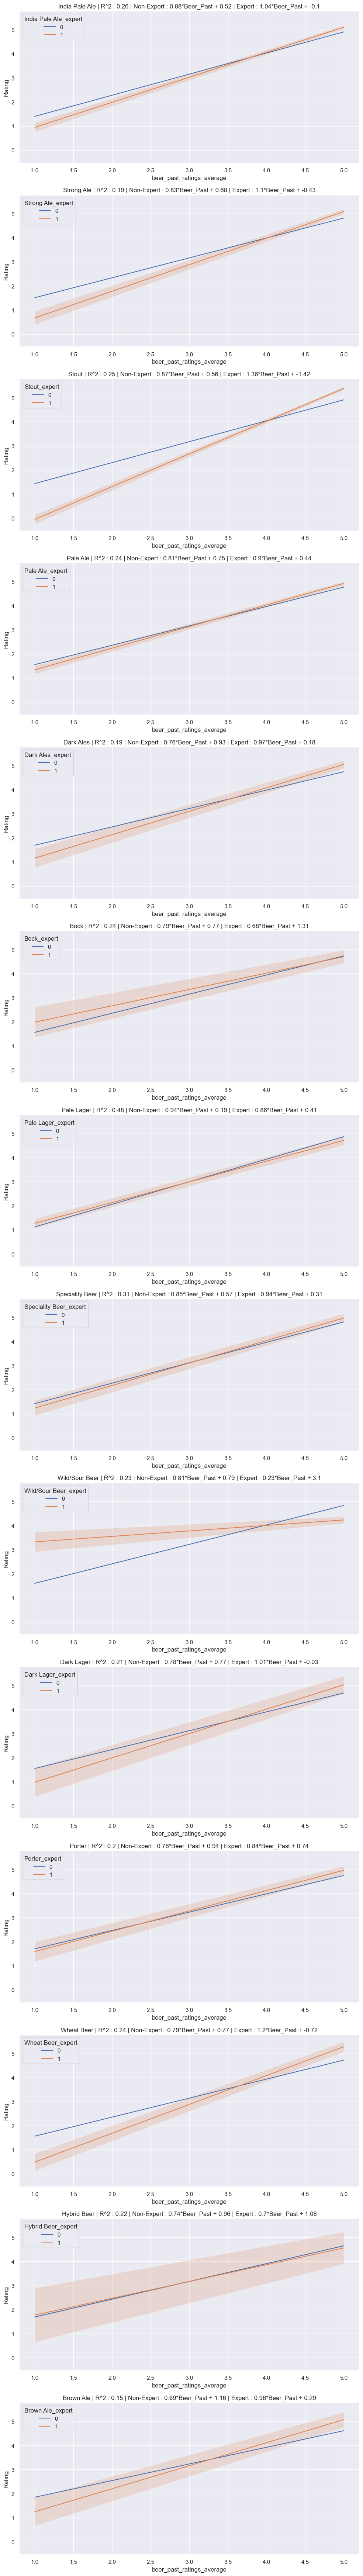

In [53]:
fig, axes = plt.subplots(14,1,figsize=(10,70),sharey=True)

for style_idx, beer_style in enumerate(df_ba_ratings["beer_global_style"].unique()):

    df_study = df_ba_ratings[df_ba_ratings["beer_global_style"] == beer_style][["user_id","date_day","beer_past_ratings_average","rating"]].merge(df_experts, how="left", on=["user_id","date_day"])
    X = df_study[[beer_style+"_expert", 'beer_past_ratings_average']]
    X.loc[:,"interaction"] = X[beer_style+"_expert"] * X["beer_past_ratings_average"]
    X.loc[:,"intercept"] = 1
    y = df_study['rating']
    reg = sm.OLS(y, X).fit()
    df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0],'intercept':[1,1,1,1]})
    #df_line = pd.DataFrame({beer_style+"_expert":[0,0,1,1],'beer_past_ratings_average':[1.0,5.0,1.0,5.0],'interaction':[0,0,1.0,5.0]})

    prediction = reg.get_prediction(df_line)
    predicted_mean = prediction.predicted_mean
    conf_int = prediction.conf_int()

    df_line["predicted_rating"] = predicted_mean
    df_line["ci_lower"] = conf_int[:, 0]
    df_line["ci_upper"] = conf_int[:, 1]

    sns.lineplot(data = df_line, x = "beer_past_ratings_average", y = "predicted_rating", hue = beer_style+"_expert", legend=True, ax=axes[style_idx])
    axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past + {round(reg.params["intercept"],2)} | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params["intercept"] + reg.params[beer_style+"_expert"],2)}")
    #axes[style_idx].set_title(f"{beer_style} | R^2 : {round(reg.rsquared.item(),2)} | Non-Expert : {round(reg.params["beer_past_ratings_average"],2)}*Beer_Past | Expert : {round(reg.params["beer_past_ratings_average"] + reg.params["interaction"],2)}*Beer_Past + {round(reg.params[beer_style+"_expert"],2)}")
    axes[style_idx].set_ylabel("Rating")

    for expert in df_line[beer_style+"_expert"].unique():
        expert_data = df_line[df_line[beer_style+"_expert"] == expert]
        axes[style_idx].fill_between(
            expert_data["beer_past_ratings_average"], 
            expert_data["ci_lower"], 
            expert_data["ci_upper"], 
            alpha=0.2  # Adjust transparency of the shaded region
        )
plt.tight_layout()
plt.show()

### Make graph of co-experts across beer styles